In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import *
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile
import shutil
import numbers

In [2]:
#torch.cuda.set_device(3)

In [3]:
path_data = Path('/scratch/bpho_data')
path_combo_src_hr = path_data/'combo_src'
path_combo_src_lr = path_data/'combo_lr_pair'
path_combo_hr = path_data/'combo_hr'
path_combo_lr = path_data/'combo_lr'
path_test_lr = path_data/'test_imgs'
path_test2_lr = path_data/'newimg'
path_models = Path('/scratch/fmonroe/models')

In [4]:
def pull_id(fn):
    return fn.split('#')[-1].split('.')[0]

pair_names_by_id = {pull_id(lrfn.name):lrfn for lrfn in path_combo_src_lr.glob('*.tif')}

def match_lr_fn(x):
    return pair_names_by_id[pull_id(x.name)]

def get_czi_shape_info(czi):
    shape = czi.shape
    axes = czi.axes
    axes_dict = {axis:idx for idx,axis in enumerate(czi.axes)}
    shape_dict = {axis:shape[axes_dict[axis]] for axis in czi.axes}
    return axes_dict, shape_dict


def build_index(axes, ix_select):
    idx = [ix_select.get(ax, 0) for ax in axes]
    return tuple(idx)

def process_tiff(fn):
    lr_match = match_lr_fn(fn)
    shutil.copy(fn, path_combo_hr/fn.name)
    shutil.copy(lr_match, path_combo_lr/fn.name)
    

def process_czi(proc_fn):
    with czifile.CziFile(proc_fn) as proc_czf:
        proc_axes, proc_shape = get_czi_shape_info(proc_czf)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        x,y = proc_shape['X'], proc_shape['Y']
        data = proc_czf.asarray()
        for channel in range(channels):
            depth = depths // 2
            idx = build_index(proc_axes, {'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float)
            save_proc_fn = path_combo_hr/f'{proc_fn.stem}_{channel:02d}_{depth:03d}.tif'
            img /= max(img.max(), 8000)
            pimg = PIL.Image.fromarray(img)
            pimg.save(save_proc_fn)
            cur_size = pimg.size
            new_size = (cur_size[0]//4, cur_size[1]//4)
            pimg.resize(new_size, resample=PIL.Image.BICUBIC).save(path_combo_lr/save_proc_fn.name)
    
def process_src(fn):
    if fn.suffix == '.tif':
        process_tiff(fn)
        pass
    elif fn.suffix == '.czi':
        process_czi(fn)

fnames = list(path_combo_src_hr.iterdir())

In [5]:
# print(len(fnames))
# for fn in progress_bar(fnames):
#     process_src(fn)

In [6]:
def get_basename(x):
    return x.name

base_names = list(set([get_basename(x) for x in list(path_combo_lr.iterdir())]))
train_names, valid_names = random_split(0.15, base_names)
valid_names = list(valid_names[0])

def is_validation_basename(x):
    return x.name in valid_names

def lr_to_hr_fn(x):
    return path_combo_hr/x.name

In [7]:
src = (GrayImageItemList
       .from_folder(path_combo_lr, '*.tif', label_class=GrayImageItemList)
       .split_by_valid_func(is_validation_basename)
       .label_from_func(lr_to_hr_fn))

In [8]:
def charbonnier_loss(inputs, targets):
    eps = 1e-6;
    d = inputs - targets
    e = torch.sqrt(d**2 + eps)
    return e.mean()


class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)
    
    
class Blur(nn.Module):
    def __init__(self):
        super().__init__()
        self.smoothing = GaussianSmoothing(1, 5, 1)
        self.pad = nn.ReflectionPad2d(2)
        
    def forward(self, input):
        return self.smoothing(self.pad(input))

In [12]:
loss = charbonnier_loss
#loss = F.mse_loss
scale=4
model = DBPNLL(num_channels=1, base_filter=8, feat = 256, num_stages=10, scale_factor=scale)
model = nn.Sequential(model, Blur())

#model = DBPNLL(num_channels=1, base_filter=16, feat = 256, num_stages=10, scale_factor=scale)
model = nn.DataParallel(model, [0,1,2,3])

In [13]:
# sz_lr = 64
# scale,bs = 4,16
# sz_hr = sz_lr*scale

# learn = build_learner(model, bs, sz_lr, sz_hr, src, loss=loss, model_dir=path_models) #, callback_fns=LossMetrics)
# learn.lr_find()
# learn.recorder.plot()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr
1,0.029794,0.024376,0.006777,0.805912,21.771336
2,0.028191,0.024416,0.007178,0.812564,21.523607
3,0.027414,0.025403,0.007776,0.808677,21.185293
4,0.027577,0.024433,0.007067,0.812254,21.593605
5,0.027665,0.024715,0.007325,0.809584,21.439959
6,0.027713,0.023883,0.006879,0.816031,21.704802
7,0.027007,0.023327,0.006699,0.818246,21.818819
8,0.027042,0.024172,0.007138,0.816043,21.549557
9,0.026785,0.023348,0.006685,0.817132,21.828472
10,0.026428,0.023197,0.006604,0.817873,21.880400


save: combo_1.0_small


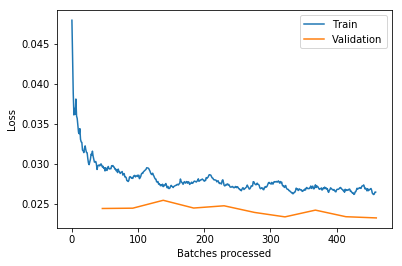

In [14]:
sz_lr = 48
scale,bs = 4,16
sz_hr = sz_lr*scale
epochs, lr = 10, 1e-3
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, 
                    save='combo_1.0_small', 
                    loss=loss, model_dir=path_models)

load: combo_1.0_small


epoch,train_loss,valid_loss,mse_loss,ssim,psnr
1,0.020282,0.018377,0.003938,0.836334,24.131056
2,0.020162,0.018143,0.003577,0.832902,24.530972
3,0.019969,0.018903,0.004412,0.838189,23.634380
4,0.019580,0.017702,0.003618,0.841800,24.482637
5,0.019478,0.017662,0.003566,0.841903,24.541929


save: combo_1.1_small


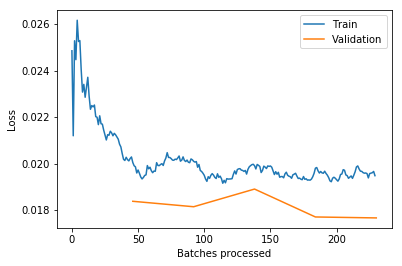

In [15]:
sz_lr = 96
scale,bs = 4,16
sz_hr = sz_lr*scale

epochs, lr = 5, 5e-4
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, model_dir=path_models,
                    load='combo_1.0_small', save='combo_1.1_small', loss=loss)

load: combo_1.1_small


epoch,train_loss,valid_loss,mse_loss,ssim,psnr
1,0.018549,0.018056,0.003664,0.832911,24.659540
2,0.019972,0.018276,0.003581,0.829793,24.749979
3,0.019263,0.018390,0.003896,0.832826,24.406612
4,0.019192,0.017883,0.003614,0.835968,24.720018
5,0.019125,0.017972,0.003806,0.836125,24.501303


save: combo_1.2_small


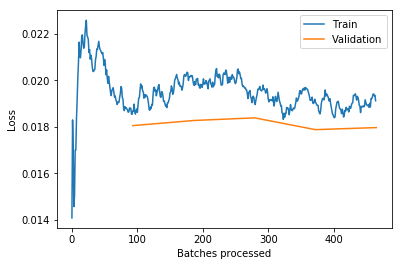

In [16]:
sz_lr = 128
scale,bs = 4,8
sz_hr = sz_lr*scale

epochs, lr = 5, 2e-4
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, model_dir=path_models,
                    load='combo_1.1_small', save='combo_1.2_small', loss=loss)

load: combo_1.2_small


epoch,train_loss,valid_loss,mse_loss,ssim,psnr
1,0.019339,0.018568,0.003795,0.830253,24.891344
2,0.021129,0.019073,0.004022,0.829882,24.640022
3,0.020739,0.018822,0.004193,0.831785,24.450356
4,0.019914,0.018621,0.003901,0.832508,24.765919
5,0.020106,0.018631,0.003893,0.832478,24.777605


save: combo_1.3_small


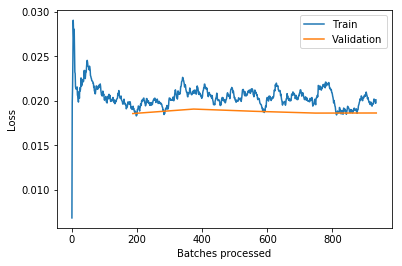

In [17]:
sz_lr = 256
scale,bs = 4,4
sz_hr = sz_lr*scale

epochs, lr = 5, 1e-4
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, model_dir=path_models,
                    load='combo_1.2_small', save='combo_1.3_small', loss=loss)

In [22]:
def my_pred(self, item:ItemBase, **kwargs):
    self.callbacks.append(RecordOnCPU())
    batch = self.data.one_item(item)
    batch = to_half(batch)
    res = self.pred_batch(batch=batch)
    pred = res[0]
    x = self.callbacks[-1].input
    x = x.float()
    pred = pred.float()
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False): pred = self.data.denorm(pred)
    self.callbacks = self.callbacks[:-1]
    ds = self.data.single_ds
    pred = ds.y.analyze_pred(pred, **kwargs)
    out = ds.y.reconstruct(pred, ds.x.reconstruct(x[0])) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
    return out, pred, res[0]

In [29]:
# loss = charbonnier_loss
# scale=4
# n_resblocks=128
# n_feats=32
# res_scale= 0.1
# model = WDSR(scale, n_resblocks, n_feats, res_scale, n_colors_in=1)

test_fns = list(path_test_lr.iterdir())
lil = []
big = []
for fn in test_fns:
    learn = None
    gc.collect()
    img = open_grayscale(fn)
    
    scale,bs = 4,4
    sz_lr = max(img.shape)
    sz_lr = min(int(sz_lr), 600)
    sz_hr = sz_lr*scale
    print(sz_lr, sz_hr)
    data = get_data(src, bs, sz_lr, sz_hr)
    learn = Learner(data, model, loss_func=F.mse_loss, model_dir=path_models).to_fp16().load('combo_1.3_small_best')
    a,b,c = my_pred(learn, img)
    img_big = Image(a.data[0:1,:,:])
    lr_fn = Path(fn.stem + '_LR.png')
    img.save(lr_fn)
    hr_fn = Path(fn.stem + '_HR.png')
    img_big.save(hr_fn)
    lil.append(img)
    big.append(img_big)
    print(lr_fn, hr_fn)

559 2236
Denoised_actin_lr_LR.png Denoised_actin_lr_HR.png
512 2048
Mito_confocal_lr_LR.png Mito_confocal_lr_HR.png
503 2012
lr_LR.png lr_HR.png
512 2048
C1-low res confocal mito and actin 4-1_LR.png C1-low res confocal mito and actin 4-1_HR.png
512 2048
C2-low res confocal mito and actin 4-1_LR.png C2-low res confocal mito and actin 4-1_HR.png
225 900
Neuron_RGB_lr_LR.png Neuron_RGB_lr_HR.png
506 2024
Mitochondria_lr_LR.png Mitochondria_lr_HR.png


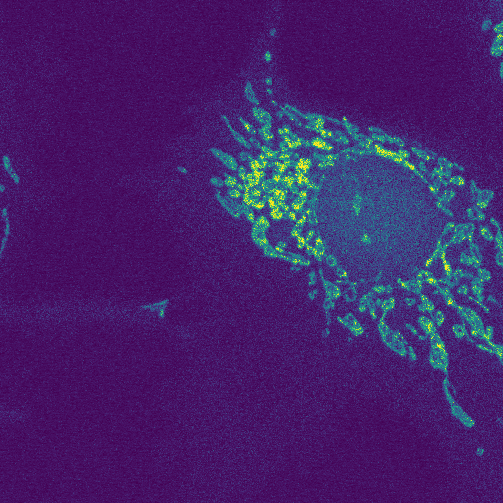

In [27]:
idx=2
l,b = lil[idx], big[idx]
l

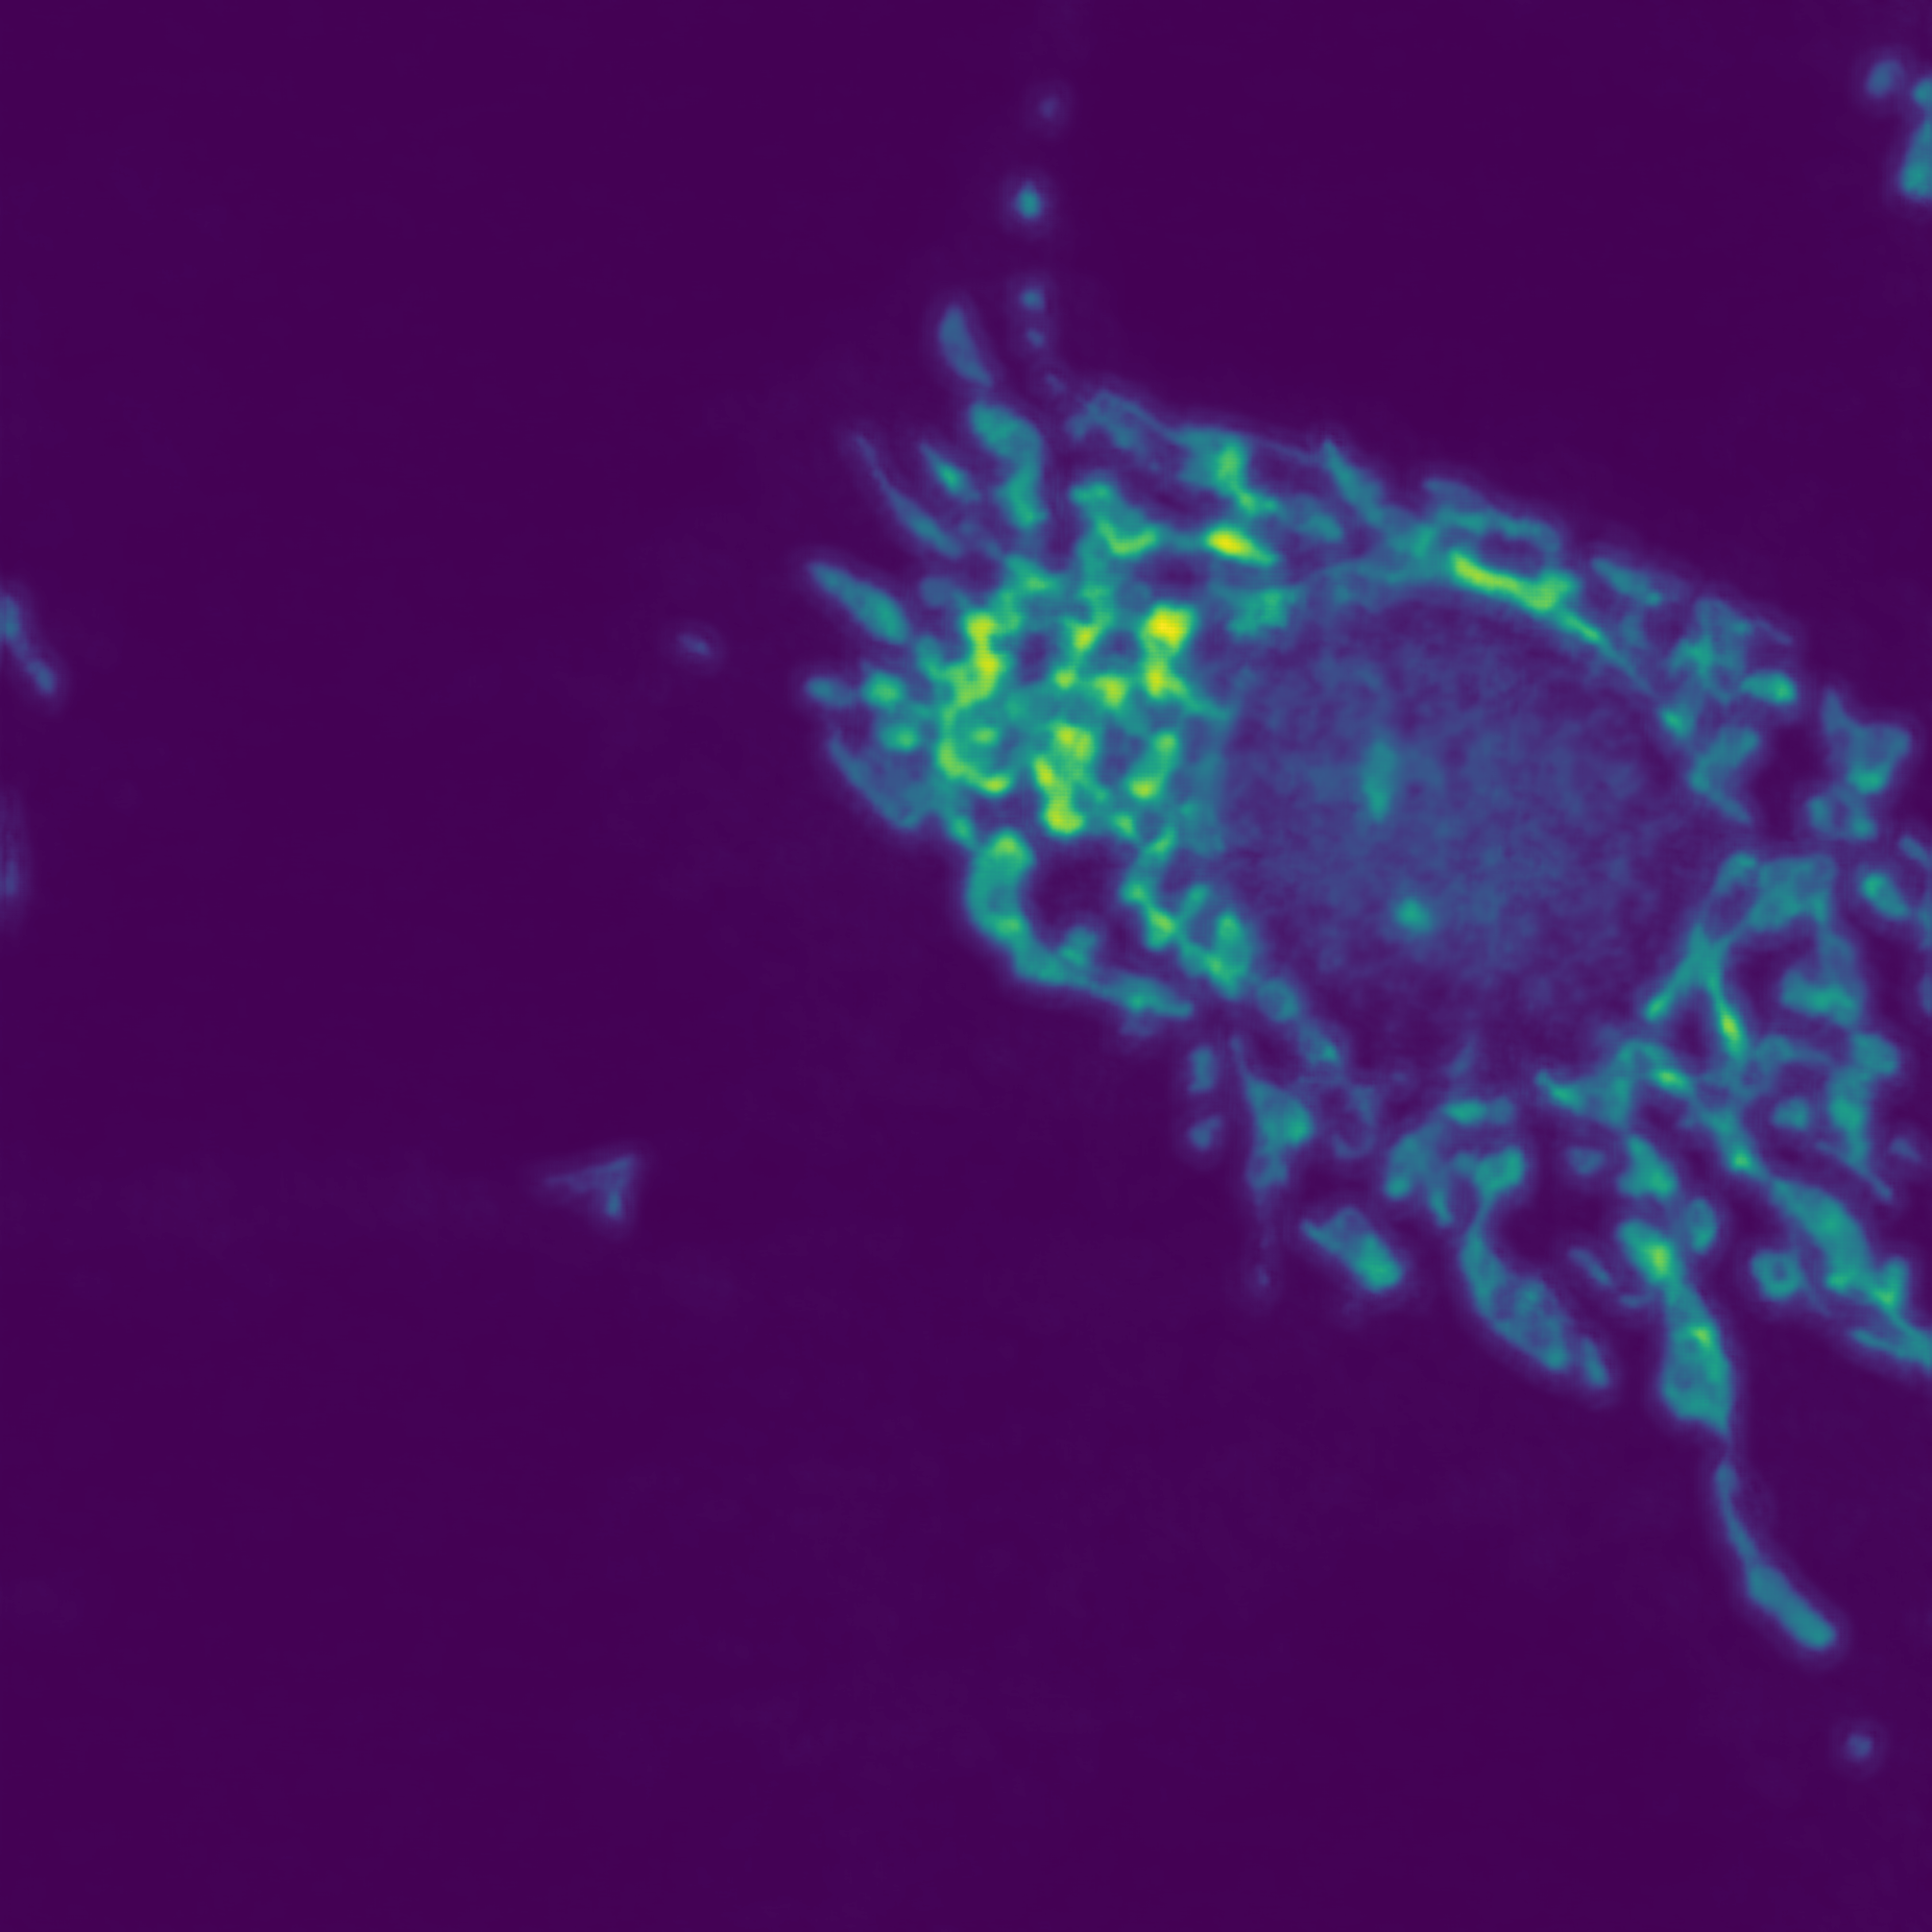

In [28]:
b